Variational message passing demo
===

ForneyLab comes with support for variational message passing (VMP) (Dauwels, 2007). In this demo we illustrate VMP by estimating the mean and precision (inverse variance) of i.i.d. samples drawn from a Gaussian distribution. The model is easily defined as 
\begin{align*}
    y_i \sim \mathcal{N}(m, w^{-1})
\end{align*}
The factor graph below shows our generative model.

```
-------------> = ---> (w)
               | 
---> = --------|----> (m)
     |         |
     ---> N <---
          | 
        (y_i)
```

Variational inference approximates the posterior over $m$ and $w$ by a recognition distribution
\begin{align*}
    p(m, w | y_{1:n}) \approx q(m)\times q(w)
\end{align*}
We minimize the KL divergence between the exact posterior and the recognition distribution by variational message passing. 

In [1]:
using(ForneyLab)

n = 100

g = FactorGraph()

# Priors
m ~ GaussianMeanVariance(constant(0.0), constant(100.0))
w ~ Gamma(constant(0.01), constant(0.01))

# Observarion model
for i = 1:n
    y_i ~ GaussianMeanPrecision(m, w)
    placeholder(y_i, :y, index=i)
end

# Assign id for ease of lookup
m.id = :m
w.id = :w
;

With the model defined, we can now specify the recognition factorization, generate a schedule for each recognition factor and compile these schedules to Julia code.

In [2]:
# Specify recognition factorization
q_m = RecognitionFactor(m)
q_w = RecognitionFactor(w)

# Generate schedules
schedule_q_m = variationalSchedule(q_m)
schedule_q_w = variationalSchedule(q_w)

# Convert schedules to Julia executable code
algo_q_m = messagePassingAlgorithm(schedule_q_m, m)
algo_q_m = replace(algo_q_m, "step!", "stepM!")
algo_q_w = messagePassingAlgorithm(schedule_q_w, w)
algo_q_w = replace(algo_q_w, "step!", "stepW!");

# Inspect the algorithm code
# println(algo_q_m)
# println("\n")
# println(algo_q_w)

We can now iteratively execute the updates for each factor, and inspect the results.

In [3]:
eval(parse(algo_q_m))
eval(parse(algo_q_w))

# Toy dataset
m_true = 3.0
w_true = 4.0
y = sqrt(1/w_true)*randn(n) + m_true
data = Dict(:y => y)

# Initial recognition distributions
marginals = Dict(:m => ProbabilityDistribution(Gaussian, m=0.0, v=100.0),
                 :w => ProbabilityDistribution(Gamma, a=0.01, b=0.01))

n_its = 2*n
for i = 1:n_its
   stepM!(marginals, data)
   stepW!(marginals, data)    
end
;

In [4]:
# Inspect the results
println("True mean: $(m_true)")
println("True precision: $(w_true)")
println("Number of samples: $(n)")
println("Sample mean: $(round(mean(y),2))")
println("Sample precision: $(round(1/var(y),2))")
println("\n----- Estimation after $(n_its) VMP updates -----")
println("Mean estimate: $(round(mean(marginals[:m]),2)), with variance $(round(var(marginals[:m]),2))")
println("Precision estimate: $(round(mean(marginals[:w]),2)), with variance $(round(var(marginals[:w]),2))")

True mean: 3.0
True precision: 4.0
Number of samples: 100
Sample mean: 3.07
Sample precision: 3.7

----- Estimation after 200 VMP updates -----
Mean estimate: 3.07, with variance 0.0
Precision estimate: 3.7, with variance 0.27


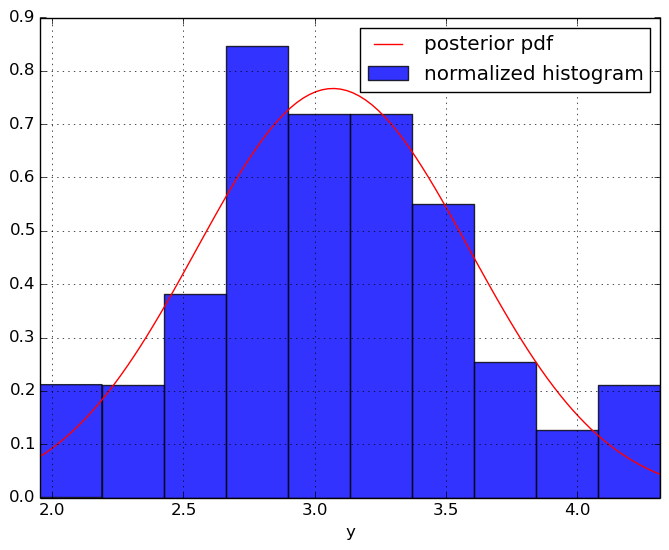

PyObject <matplotlib.text.Text object at 0x7f1cce607610>

In [10]:
using PyPlot

plt[:hist](y, normed=true, label="normalized histogram", alpha=0.8)
y_til = linspace(minimum(y), maximum(y), 100)
p_y = sqrt(mean(marginals[:w])/(2*pi))*exp(-0.5*mean(marginals[:w])*(y_til - mean(marginals[:m])).^2)
plot(y_til, p_y, color="red", label="posterior pdf")
xlim(minimum(y), maximum(y))
legend()
grid("on")
xlabel("y")